In [1]:
# Imports
import autograd.numpy as np
from autograd import grad
import matplotlib
import pandas as pd
import os
from scipy.optimize import curve_fit, minimize, least_squares, basinhopping, OptimizeWarning
import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import product
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
from os import CLD_CONTINUED
import warnings
import numpy as np
from sklearn.metrics._plot.confusion_matrix import unique_labels
import scipy.interpolate
from functools import partial

np.seterr(over='ignore')
np.seterr(invalid='ignore')
warnings.filterwarnings("ignore", category=OptimizeWarning)

from IPython import get_ipython
ip = get_ipython()
if 'IPKernelApp' in ip.config:
    LOCAL_DIR = os.getcwd()
else:
    LOCAL_DIR = os.path.dirname(os.path.abspath(__file__))
if LOCAL_DIR == '/content':
  LOCAL_DIR = "/content/drive/MyDrive/scaling_law_survey/"
print(LOCAL_DIR)

CHINCHILLA_PARAMS_LOG = np.array([np.log(406.4), np.log(410.7), np.log(1.69), 0.3392, 0.2849])

KAPLAN_PARAMS_LOG = np.array([np.log(6.4e13), np.log(1.8e13), 0, 0.076, 0.103])

/Users/margaretli/gitfiles/scaling_laws/scaling


In [2]:
os.listdir(f"{LOCAL_DIR}/data")

['rsld',
 'dense.csv',
 'data copy.csv',
 'data.csv',
 'gshard.csv',
 'epoch_ai.csv',
 'spm.csv',
 'LBFGS.png']

In [3]:
# constants relating to https://github.com/formll/resolving-scaling-law-discrepancies

COLORS = [c for c in matplotlib.colors.TABLEAU_COLORS]
COLORS.append('indigo')
COLORS.append('tan')#[:-2]
COLORS.append('k')

# dataset, hparams, warmup, decay, param_count, val = config

FIGURE1_CONFIGS = [
    ('rw', 'base', 'long', 'kaplan', 'kaplan', 'train'),
    ('rw', 'base', 'long', 'kaplan', 'standard', 'val'),
    ('rw', 'base', 'short', 'kaplan', 'standard', 'val'),
    ('rw', 'base', 'short', 'chinchilla', 'standard', 'val'),
    ('rw', 'tuned', 'short', 'const', 'standard', 'val')
]

ISOFLOP_ARGS = {
    ('kaplan', 'train'): dict(loss_key='train/loss_smoothed', flop_per_token_key='flops_per_token_no_att_no_embed', n_key='params_no_embed'),
    ('standard', 'val'):  dict(loss_key='val/loss', flop_per_token_key='flops_per_token', n_key='params'),
    ('standard', 'train'): dict(loss_key='train/loss_smoothed', flop_per_token_key='flops_per_token', n_key='params'),
    ('attention', 'train'): dict(loss_key='train/loss_smoothed', flop_per_token_key='flops_per_token_att', n_key='eff_params_att'),
}

NAME_TO_CONFIG_DICT = {
    'kaplan': ('rw', 'base', 'long', 'kaplan', 'kaplan', 'train'),
    'w_emb': ('rw', 'base', 'long', 'kaplan', 'standard', 'val'), #: 'Counting last layer FLOPs',
    'w_emb_short_wu': ('rw', 'base', 'short', 'kaplan', 'standard', 'val'), #: 'Correcting warmup',
    'chinchilla': ('rw', 'base', 'short', 'chinchilla', 'standard', 'val'), #: 'Cosine decay', # original Chinchilla?
    'optuned': ('rw', 'tuned', 'short', 'const', 'standard', 'val'), #: 'Optimizer tuning (no decay)',
    'optuned_train': ('rw', 'tuned', 'short', 'const', 'standard', 'train'), #: 'Optimizer tuning (no decay) - train',
    'optuned_kaplan': ('rw', 'tuned', 'long', 'const', 'kaplan', 'train'), #: '', # kaplan tuned
    'kaplan_w_emb_attn': ('rw', 'base', 'long', 'kaplan', 'attention', 'train'), #: 'Counting last layer\nand attention FLOPs',
    'kaplan_w_emb_attn_train_short_wu': ('rw', 'base', 'short', 'kaplan', 'attention', 'train'), #: 'Correcting warmup',
    'kaplan_w_emb_attn_train_short_wu_decay': ('rw', 'base', 'short', 'chinchilla', 'attention', 'train'), #: 'Cosine decay',
    '': ('rw', 'tuned', 'short', 'const', 'attention', 'train'), #: 'Optimizer tuning (no decay)',
}

def get_color(i, clist=COLORS):
    return clist[i % len(clist)]
    
CONFIG_DICT_COLOR = {
    ('rw', 'base', 'long', 'kaplan', 'kaplan', 'train'): get_color(4),
    ('rw', 'base', 'long', 'kaplan', 'standard', 'val'): get_color(0),
    ('rw', 'base', 'short', 'kaplan', 'standard', 'val'): get_color(1),
    ('rw', 'base', 'short', 'chinchilla', 'standard', 'val'): get_color(2),
    ('rw', 'tuned', 'short', 'const', 'standard', 'val'): get_color(3),

    ('rw', 'tuned', 'long', 'const', 'kaplan', 'train'): get_color(6),
    ('rw', 'sweep', 'short', 'const', 'standard', 'train'): get_color(7),

    ('rw', 'base', 'long', 'kaplan', 'attention', 'train'): get_color(0),
    ('rw', 'base', 'short', 'kaplan', 'attention', 'train'): get_color(1),
    ('rw', 'base', 'short', 'chinchilla', 'attention', 'train'): get_color(2),
    ('rw', 'tuned', 'short', 'const', 'attention', 'train'): get_color(3),
}

FLOP_VALS = 1e17 * 2 ** np.arange(-3.0, 9, 1.0)

CHINCHILLA_FLOPS = 5.88e23
CHINCHILLA_STR = 'C_{C}'

RW_SEED_CONFIG = dict(noise_low=0.002, noise_high=0.05, l_threshold_high=7, l_threshold_low=3)
OWT2_SEED_CONFIG = dict(noise_low=0.01, noise_high=0.1, l_threshold_high=6, l_threshold_low=3)
SEED_ARGS = {k:RW_SEED_CONFIG for k in CONFIG_DICT_COLOR}

SEED_ARGS.update({('owt2', b, c, d, e, f): OWT2_SEED_CONFIG for _, b, c, d, e, f in CONFIG_DICT_COLOR})

SEED_ARGS.update({('rw', 'tuned', 'short', 'const', 'standard', 'train'): RW_SEED_CONFIG})
SEED_ARGS.update({('rw', 'tuned', 'short', 'const', 'kaplan', 'train'): RW_SEED_CONFIG})

In [4]:
# from https://github.com/formll/resolving-scaling-law-discrepancies

def fetch_flop(df, flop, loss_key='train/loss_smoothed', warmup_remove_factor=1e-12, n_key='params', 
               seq_len=2048, bs_key='bs', keep_bs_lr_keys=False,
               flop_per_token_key='flops_per_token', flop_tolerance=0.1):
    out = []
    for _, row in df.iterrows():
        if len(row[loss_key]) == 0:
            continue
        loss_vals = row[loss_key].dropna().groupby(level=0).mean().sort_index()
        step_vals = loss_vals.index
        mask = step_vals >= ((warmup_remove_factor * row.warmup_tokens) / row.bs / row.seq_len)
        loss_vals = loss_vals[mask]
        loss_vals.index = loss_vals.index.astype(float) * seq_len * row[bs_key] * row[flop_per_token_key]
        flop_vals = loss_vals.index
        
        if len(loss_vals) == 0:
            continue        
        flop_ind = loss_vals.index.searchsorted(flop)
        if flop_ind > 0:
            flop_ind += -1 + np.abs(np.log(flop_vals[flop_ind-1:flop_ind+1]/flop)).argmin()
        rel_err = np.exp(np.abs(np.log(flop_vals[flop_ind]/flop))) - 1
        if rel_err > flop_tolerance:
            continue

        if len(flop_vals) > 1:
            flop_slice = flop_vals[max(0,flop_ind-5):flop_ind+5]
            loss_slide = loss_vals.iloc[max(0,flop_ind-5):flop_ind+5]
            loss_interp = np.exp(np.interp(np.log(flop), np.log(flop_slice), np.log(loss_slide)))
            out.append(dict(n=row[n_key], t=flop / row[flop_per_token_key], loss=loss_interp))
        else:
            out.append(dict(n=row[n_key], t=loss_vals.index[flop_ind] / row[flop_per_token_key], loss=loss_vals.iloc[flop_ind]))
        if keep_bs_lr_keys:
            out[-1].update({k: row[k] for k in [bs_key, 'lr']})

    return pd.DataFrame(out)


# def power_law_fit(df, x, y, weighted=False):
# def fit_compute_optimal_power_laws(optimal_pairs, bootstrap_data, bootstrap_num=None, bootstrap_num_loss=200, fit_loss=True):


def get_noise_for_loss(loss, bootstrap_iters, noise_low=0.005, noise_high=0.1, l_threshold_high=6, l_threshold_low=3):
    basic_noise = np.random.normal(0, 1, (bootstrap_iters, len(loss) // bootstrap_iters))
    noise_adjusted_losses = np.zeros((bootstrap_iters, len(loss) // bootstrap_iters))

    for i in range(len(loss) // bootstrap_iters):
        if np.log(loss[i]) >= l_threshold_high:
            log_noise = np.log(noise_high)
        elif np.log(loss[i]) <= l_threshold_low:
            log_noise = np.log(noise_low)
        else:
            log_noise = np.interp(np.log(loss[i]), [np.log(l_threshold_low), np.log(l_threshold_high)], [np.log(noise_low), np.log(noise_high)])
        noise_factor = np.exp(log_noise)
        noise_adjusted_losses[:, i] = loss[i] + noise_factor * basic_noise[:, i]
        
    return noise_adjusted_losses.flatten()


def vectorized_interp_with_seed_noise(df, n_interp_, bootstrap_iters, seed_noise=None,
                                      min_std_factor=0.33, tok_or_n='n'):
    if seed_noise is None:
        seed_noise = {}
    interp_num = len(n_interp_)
    stacked_df = pd.concat([df] * bootstrap_iters).reset_index(drop=True)
    stacked_df['loss'] = get_noise_for_loss(stacked_df.loss, bootstrap_iters=bootstrap_iters, **seed_noise)

    batch_ids = np.repeat(np.arange(bootstrap_iters), len(df))
    stacked_df['batch_id'] = batch_ids
    stacked_df.sort_values(by=['batch_id', tok_or_n], inplace=True)

    def batch_interp(batch):
        interp = scipy.interpolate.Akima1DInterpolator(np.log(batch[tok_or_n]), np.log(batch['loss']))
        return np.exp(interp(np.log(n_interp_)))

    interpolated_values = stacked_df.groupby('batch_id').apply(batch_interp)

    # Find the index of the minimum interpolated loss value per batch
    min_indices = interpolated_values.apply(np.argmin)
    results = [n_interp_[idx] if idx != 0 and idx != interp_num - 1 else None for idx in min_indices]
    valid_results_loss = [interpolated_values[i][idx] for i, idx in enumerate(min_indices) if idx != 0 and idx != interp_num - 1]
    # Filter None values and calculate statistics
    valid_results = [result for result in results if result is not None]
    if len(valid_results) < bootstrap_iters // 2:
        return None, 0, None, None, None
    else:
        n_star_std_ = np.std(np.log(valid_results))
        min_std = min_std_factor * np.log(n_interp_[1] / n_interp_[0])  # this assumes a roughly uniform grid
        n_star_std_ = max(n_star_std_, min_std) * (bootstrap_iters / len(valid_results))
        loss_star_std_ = np.std(np.log(valid_results_loss))
        min_std_loss = min_std_factor * min([np.log(df.loss.iloc[i+1] / df.loss.iloc[i]) for i in range(len(df) - 1)])
        loss_star_std_ = max(loss_star_std_, min_std_loss) * (bootstrap_iters / len(valid_results_loss))
        return n_star_std_, None, valid_results, valid_results_loss, loss_star_std_


def interpolation(df_, interp_num, bootstrap_iters, seed_noise, min_std_factor, interp_num_multiplier, std_method, col):
    interp_ = np.geomspace(df_[col].min(), df_[col].max(), interp_num)
    df_ = df_.sort_values(col)
    interpolator = scipy.interpolate.Akima1DInterpolator(np.log(df_[col]), np.log(df_.loss))
    loss_interp_ = np.exp(interpolator(np.log(interp_)))
    star_ind_ = loss_interp_.argmin()

    if std_method == 'add_seed_noise':
        star_std_, _, noised_stars_, noised_loss, loss_star_std = vectorized_interp_with_seed_noise(
            df_, interp_, bootstrap_iters, seed_noise, min_std_factor * interp_num_multiplier, tok_or_n=col)
    else:
        star_std_ = None
        noised_stars_ = []

    return star_ind_, star_std_, noised_stars_, interp_, loss_interp_, noised_loss, loss_star_std


def interp_flop(big_df, loss_key, flop_vals=[8e16, 3e17, 6e17, 3e18, 6e18, 1e19], groupby_action='min',
                warmup_remove_factor=1e-12,
                interp_num_multiplier=25,
                n_key='params', n_star_std_method='add_seed_noise', t_star_std_method='add_seed_noise',
                bootstrap_iters=1000,
                min_std_factor=0.33,
                seed_noise=None, flop_tolerance=0.1,
                flop_per_token_key='flops_per_token',
                bs_median_as_obs=True,
                keep_bs_lr_keys=False,
                ):
    out = []
    optimal_pairs = []
    max_loss, min_loss = 0, 1e12

    for c in flop_vals:
        df_ = fetch_flop(big_df, c, loss_key=loss_key, 
                         warmup_remove_factor=warmup_remove_factor, n_key=n_key, 
                         flop_per_token_key=flop_per_token_key,
                         flop_tolerance=flop_tolerance, keep_bs_lr_keys=keep_bs_lr_keys)

        if len(df_) < 3:
            out.append(dict(n_interp=None, loss_interp=None, t_interp=None, 
                            loss_interp_tok=None, opt_ind=None, opt_tok_ind=None, flops=c))
            continue
        if 'bs' in df_.columns and 'lr' in df_.columns:
            df_sweep_opt_eta = df_.groupby(['n','bs']).apply(minimize_with_interp).drop(['bs', 'n'], axis=1).reset_index()
            df_sweep_opt_eta_and_bs = df_sweep_opt_eta.groupby(['n']).apply(lambda x: minimize_with_interp(x, x_key='bs')).drop('n', axis=1).reset_index()
            df_ = df_sweep_opt_eta_and_bs[['n']]
            df_['t'] 
            # print(df_.iloc[0].loss)
        elif groupby_action == 'min':
            df_ = df_.loc[df_.groupby(['n']).loss.idxmin()]
        elif groupby_action == 'mean':
            df_ = df_.groupby('n').mean()
        else:
            raise ValueError(f'Unknown groupby_action {groupby_action}')
        df_ = df_.reset_index()

        interp_num = (len(df_) - 1) * interp_num_multiplier

        max_loss, min_loss = max(max_loss, df_.loss.max()), min(min_loss, df_.loss.min())
        
        n_star_ind_, n_star_std_, noised_n_stars_, n_interp_, loss_interp_, noised_loss, loss_star_std = interpolation(
            df_, interp_num, bootstrap_iters, seed_noise, min_std_factor, interp_num_multiplier, n_star_std_method, 'n')

        t_star_ind_, t_star_std_, noised_t_stars_, t_interp_, loss_interp_tok_, noised_loss, _ = interpolation(
            df_, interp_num, bootstrap_iters, seed_noise, min_std_factor, interp_num_multiplier, t_star_std_method, 't')
        
        if n_star_ind_ != 0 and n_star_ind_ != interp_num -1 and noised_n_stars_ is not None:
            optimal_pairs.append(
                dict(flops=c, n=n_interp_[n_star_ind_], t=t_interp_[t_star_ind_], multiplier=c / 6 / (n_interp_[n_star_ind_]**2),
                     loss=loss_interp_.min(), loss_t=loss_interp_tok_.min(),
                     n_vals=df_.n.values, t_vals=df_.t.values, loss_vals=df_.loss
                    )
            )
        else:
            optimal_pairs.append(
                dict(flops=c, n=None, t=None, loss=None, loss_t=None,
                        n_vals=df_.n.values, t_vals=df_.t.values, loss_vals=df_.loss
                    )
            )
        out.append(
            dict(n_interp=n_interp_, loss_interp=loss_interp_, 
                 t_interp=t_interp_, loss_interp_tok=loss_interp_tok_, 
                 opt_ind=n_star_ind_, opt_tok_ind=t_star_ind_, flops=c, 
                 orig_n=df_.n, orig_t=df_.t, orig_loss=df_.loss)
            )
        if n_star_std_method == 'add_seed_noise':
            out[-1]['n_star_std'] = n_star_std_
            out[-1]['n_stars'] = noised_n_stars_
            out[-1]['multiplier_stars'] = (c / (6 * np.array(noised_n_stars_)**2)) if noised_n_stars_ is not None else None
            optimal_pairs[-1]['n_star_std'] = n_star_std_ 
            
            out[-1]['multiplier_star_std'] = 2 * n_star_std_ if n_star_std_ is not None else None
            optimal_pairs[-1]['multiplier_star_std'] = 2 * n_star_std_ if n_star_std_ is not None else None

            out[-1]['t_star_std'] = t_star_std_
            out[-1]['t_stars'] = noised_t_stars_
            optimal_pairs[-1]['t_star_std'] = t_star_std_

            out[-1]['loss_stars'] = noised_loss
            out[-1]['loss_star_std'] = loss_star_std 
            optimal_pairs[-1]['loss_star_std'] = loss_star_std

    out_df = pd.DataFrame(out)
    optimal_pairs_df = pd.DataFrame(optimal_pairs)

    if bs_median_as_obs:
        for ind, row in optimal_pairs_df.iterrows():
            if row['n'] is None or np.isnan(row['n']):
                continue
            flop = row['flops']
            data_row = out_df.set_index('flops').loc[flop]
            for key in ['n', 't', 'multiplier', 'loss']:
                optimal_pairs_df.at[ind, key] = np.median(data_row[key + '_stars']) if data_row[key + '_stars'] is not None else row[key]

    return out_df, optimal_pairs_df, max_loss, min_loss


In [5]:
# from https://github.com/formll/resolving-scaling-law-discrepancies
def precise_flops_per_token_chinchilla(width, depth):
    seq_len = 2048
    vocab_size = 50432
    num_heads = 4
    width = width.astype(float)
    depth = depth.astype(float)

    embeddings = 2 * seq_len * width

    attention = 2 * 3 * seq_len * (width ** 2)
    kq_logits = 2 * seq_len * seq_len * width
    softmax = 3 * num_heads * seq_len * seq_len
    softmax_q_red = 2 * seq_len * seq_len * width
    final_linear = 2 * seq_len * (width ** 2)
    attention += kq_logits + softmax + softmax_q_red + final_linear

    ffw_size = 4 * width # check this, in the paper it is 4 * width
    dense_block = 4 * seq_len * width * ffw_size
    final_logits = 2 * seq_len * width * vocab_size
    forward_pass = embeddings + depth * attention + depth * dense_block + final_logits
    backward_pass = 2 * forward_pass
    return (forward_pass + backward_pass) / seq_len
    
def precise_param_count_open_lm(width, depth, vocab_size=50432):
    d_ff = 256 * (((2 * 4 * width / 3).astype(int) + 256 - 1) // 256)
    return (4 * width + 3 * d_ff) * width * depth + vocab_size * width
    
def apply_smoothing_filter(df, filter_func, compensate_for_logging_delay=True, key='train/loss', **filter_args):
    out = []
    for _, row in df.iterrows():
        if len(row[key]) == 0:
            out.append(None)
            continue
        filtered = filter_func(row[key].dropna(), **filter_args)
        if compensate_for_logging_delay:
            filtered.index = filtered.index - np.diff(filtered.index, prepend=0)/2
        out.append(filtered)
    return out

def proportional_sliding_window_filter(x, p=0.05):
    # assert that the index of x has constant increments?
    x_cumsum = x.cumsum().values
    x_cumsum_pad = np.concatenate([[0], x_cumsum])
    inds = np.arange(len(x))
    inds_up = np.minimum(inds + np.floor(p * inds).astype(int), len(x)-1)
    inds_down = np.maximum(0, inds - np.floor(p * inds).astype(int))
    inds_new = (inds_up + inds_down)/2
    index_new = np.interp(inds_new, inds, x.index)
    try:
        x_series = pd.Series((x_cumsum[inds_up] - x_cumsum_pad[inds_down]) / (inds_up - inds_down+1), 
                     index=index_new, name=x.name + '_smoothed')
    except:
        # print(x)
        x_series = pd.Series((x_cumsum[inds_up] - x_cumsum_pad[inds_down]) / (inds_up - inds_down+1), 
                     index=index_new, name="" + '_smoothed')
    return x_series
    
def process_big_df(big_df):
    big_df = big_df.copy()

    # Counting parameters
    big_df['params_active'] = (12 * (big_df.width**2) * big_df.depth + big_df.vocab_size * big_df.width).astype(float)
    big_df['params_active_precise'] = precise_param_count_open_lm(big_df.width, big_df.depth)
    big_df['params_no_embed'] = precise_param_count_open_lm(big_df.width, big_df.depth, vocab_size=0)
    big_df['params_all'] = 12 * (big_df.width**2) * big_df.depth + (big_df.seq_len + 2 * big_df.vocab_size) * big_df.width
    
    # Counting FLOPs
    big_df['flops_per_token_att_no_embed'] = 6 * big_df['params_no_embed'] + 6 * big_df.seq_len * big_df.width * big_df.depth
    big_df['flops_per_token_att'] = 6 * big_df['params_active_precise']  + 6 * big_df.seq_len * big_df.width * big_df.depth
    big_df['flops_per_token_cc'] = precise_flops_per_token_chinchilla(big_df['width'], big_df['depth'])
    big_df['flops_per_token_no_att'] = 6 * big_df['params_active_precise']
    big_df['flops_per_token_no_att_no_embed'] = 6 * big_df['params_no_embed']
    big_df['flops_per_token'] = big_df['flops_per_token_no_att']

    big_df['params'] = big_df['flops_per_token'] / 6 
    big_df['eff_params_att'] = big_df['flops_per_token_att'] / 6


    big_df['train/loss_smoothed'] = apply_smoothing_filter(big_df, proportional_sliding_window_filter, compensate_for_logging_delay=True, key='train/loss')
    for k in big_df: 
        if k.startswith('train/') and k.endswith('_loss'):
            big_df[k + '_smoothed'] = apply_smoothing_filter(big_df, proportional_sliding_window_filter, compensate_for_logging_delay=False, key=k)
    return big_df

In [186]:
col_names = ['C', 'D', 'N', 'lr', 'Avg Train Loss', 'Max Train Loss', 'C4 Eval PPL', 'Wiki Eval PPL', 'C4 Eval Loss', 'Wiki Eval Loss']

def get_local_data(csv_file, data_selection="opt_lr", n_field_name = "N", d_field_name = "D", loss_field_name='loss', c_field_name="C", col_names=col_names):
    mins_only = []
    df = pd.read_csv(csv_file, usecols=col_names,)
    df.dropna(subset=[loss_field_name], inplace=True)

    if 'lr' in df.columns:
        df = df.loc[(df['lr'] >= 0)]
    if d_field_name not in df.columns:
        df[d_field_name] = df[c_field_name] / (df[n_field_name] * 6)

    if data_selection:
        if data_selection[:9] == "fixed_lr_":
            lr = float(data_selection[9:])
            df = df[df["lr"] == lr]
        elif data_selection == "max_model_100m":
            df = df[df[n_field_name] < 1.3e8 ]
        elif data_selection == "low_ratio":
            df = df[df[d_field_name]/df[n_field_name] < 18 ]
        elif data_selection == "high_ratio":
            df = df[df[d_field_name]/df[n_field_name] > 22 ]
        n_vals = df[n_field_name].unique()
        d_vals = sorted(df[d_field_name].unique())
        for n in n_vals:
            for d in d_vals:
                cd_df = df[(df[n_field_name] == n) & (df[d_field_name] == d)]
                if cd_df.empty:
                    continue
                # if data_selection == "opt_lr":
                if data_selection is not None:
                    min_index = cd_df[loss_field_name].idxmin()

                    
                    
                mins_only.append(cd_df.loc[min_index])
        df = pd.DataFrame(mins_only)

    # print(df)
    return df

In [7]:
def get_rsld_data(config_name):
    df = pd.read_pickle(f'{LOCAL_DIR}/data/rsld/experiment_results.pickle.xz', compression='xz')
    df = process_big_df(df)
    config = NAME_TO_CONFIG_DICT[config_name]
    dataset, hparams, warmup, decay, param_count, val = config
    isoflop_args = ISOFLOP_ARGS[config[-2:]]
    df = df.query(f"dataset=='{dataset}' and hparams=='{hparams}' and warmup=='{warmup}' and decay=='{decay}'")

    flops_field_name = isoflop_args['flop_per_token_key']
    loss_key = isoflop_args['loss_key']
    for ind, row in df.iterrows():
        row[f"{loss_key}"].index = row[f"{loss_key}"].index.astype(float) * row['seq_len'] * row['bs']
        df.loc[ind, f'last_{loss_key}_C'] = row[loss_key].index[-1] * row[flops_field_name]
        df.loc[ind, f'last_{loss_key}_D'] = row[loss_key].index[-1] 
        df.loc[ind, f'last_{loss_key}'] = row[loss_key].iloc[-1]

    df['loss'] = df[loss_key]
    df['N'] = df[isoflop_args['n_key']]
    df['C'] = df[f'last_{loss_key}_C']
    return df

def get_rsld_data_interp(config_name,
                          flop_vals=FLOP_VALS,
                          seed=42, seed_noise_args=SEED_ARGS, 
                          keep_bs_lr_keys=False
                          ):
    df = pd.read_pickle(f'{LOCAL_DIR}/data/rsld/experiment_results.pickle.xz', compression='xz')
    df = process_big_df(df)
    config = NAME_TO_CONFIG_DICT[config_name]
    dataset, hparams, warmup, decay, param_count, val = config
    isoflop_args = ISOFLOP_ARGS[config[-2:]]
    show_df = df.query(f"dataset=='{dataset}' and hparams=='{hparams}' and warmup=='{warmup}' and decay=='{decay}'")
    
    np.random.seed(seed)
    
    if len(show_df) == 0:
        raise Error("chosen config has no data")
        
    data, optimal_pairs, max_loss, min_loss = interp_flop(
        show_df, seed_noise=seed_noise_args[config], 
        flop_vals=flop_vals, **isoflop_args,
        keep_bs_lr_keys=keep_bs_lr_keys,
    )


In [8]:
df = get_rsld_data(config_name='kaplan')
df.columns

/var/folders/pc/yg40syl127q3j7xp3nm_zncc0000gn/T/ipykernel_75813/3788970814.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[ind, f'last_{loss_key}_C'] = row[loss_key].index[-1] * row[flops_field_name]
/var/folders/pc/yg40syl127q3j7xp3nm_zncc0000gn/T/ipykernel_75813/3788970814.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[ind, f'last_{loss_key}_D'] = row[loss_key].index[-1]
/var/folders/pc/yg40syl127q3j7xp3nm_zncc0000gn/T/ipykernel_75813/3788970814.py:16: SettingWithCopyWarning: 
A 

Index(['dataset', 'hparams', 'warmup', 'decay', 'width', 'depth', 'val/loss',
       'val/loss_std', 'train/loss', 'train/batch_time', 'train/data_time',
       'train/lr', 'warmup_tokens', 'beta1', 'beta2', 'world_size', 'lr',
       'seed', 'seq_len', 'vocab_size', 'grad_clip_norm', 'optimizer',
       'precision', 'qk_norm', 'z_loss_coefficient', 'bs', 'independent_wd',
       'max_step', 'ckpt_path', 'params_active', 'params_active_precise',
       'params_no_embed', 'params_all', 'flops_per_token_att_no_embed',
       'flops_per_token_att', 'flops_per_token_cc', 'flops_per_token_no_att',
       'flops_per_token_no_att_no_embed', 'flops_per_token', 'params',
       'eff_params_att', 'train/loss_smoothed', 'last_train/loss_smoothed_C',
       'last_train/loss_smoothed_D', 'last_train/loss_smoothed', 'loss', 'N',
       'C'],
      dtype='object')

In [189]:
def get_random_indices(
    indices,
    num_sets=4000,
    seed=42,
):    
    np.random.seed(seed)
    random_indices = [np.random.choice(indices, size=len(indices), replace=True) for _ in range(num_sets)]
    return random_indices

def filter_data(N, D, losses, indices, nr_of_models_excluded=0, pct_of_models_excluded=0):
    sorted_losses = sorted(losses)
    if nr_of_models_excluded:
        indices = [i for i in range(len(N)) if losses[i] < sorted_losses[-nr_of_models_excluded]]
    elif pct_of_models_excluded:
        indices = [i for i in range(len(N)) if losses[i] < sorted_losses[int(-pct_of_models_excluded)]]
    return indices

def get_data(data_name, rsld_config_name="kaplan", nr_of_models_excluded=0, n_field_name = "N", d_field_name = "D", loss_field_name="loss", c_field_name="C", data_selection="opt_lr"):    

    if data_name == "ours":
        csv_file = f"{LOCAL_DIR}/data/data.csv"
        training_df = get_local_data(csv_file=csv_file, n_field_name=n_field_name, d_field_name=d_field_name, loss_field_name=loss_field_name, c_field_name=c_field_name, 
                                     col_names=None, data_selection=data_selection)
    elif data_name == "epoch_ai":
        csv_file = f"{LOCAL_DIR}/data/epoch_ai.csv"
        training_df = get_local_data(csv_file=csv_file, col_names=None, )
    elif data_name == "rsld":
        training_df = get_rsld_data(config_name=rsld_config_name)
    elif data_name == "rsld_isoflop":
        training_df = get_rsld_data_isoflop(config_name=rsld_config_name)
    else:
        raise Error("type of data to use not recognized")

    N = training_df[n_field_name].values
    D = training_df[d_field_name].values
    losses = training_df[loss_field_name].values
    indices = list(range(len(N)))

    return N, D, losses, indices

In [206]:
# partially from https://github.com/epoch-research/analyzing-chinchilla

import autograd.numpy as np
from autograd.scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import erf


# Define the log-sum-exp function
def log_sum_exp_chinch(a, b, e, alpha, beta, N, D):
    return np.log(np.exp(a - alpha * np.log(N)) + np.exp(b - beta * np.log(D)) + np.exp(e))

def log_sum_exp_kaplan(a, b, e, alpha, beta, N, D):
    return np.log(np.exp((alpha / beta) * (a - np.log(N))) + np.exp(b - np.log(D))) * beta

# Define the Huber loss function
def custom_huber_loss(y_true, y_pred, delta=1e-3):
    # Calculate the difference
    diff = y_true - y_pred
    # Calculate the condition for Huber loss
    cond = np.abs(diff) <= delta
    # Apply Huber loss formula
    loss = np.where(cond, 0.5 * diff**2, delta * (np.abs(diff) - 0.5 * delta))
    return np.sum(loss)

def huber_normalizing_factor(delta=1e-3):
    return np.sqrt(2*np.pi) * (1 - 2*norm.sf(delta)) + 2 * np.exp(-0.5*delta**2)/delta

def huber_logpdf(x, delta=1e-3, loc=0, scale=1):
    x = (x-loc)/scale

    cond = np.abs(x) <= delta
    loss = np.where(cond, 0.5 * x**2, delta * (np.abs(x) - 0.5 * delta))
    return -loss - np.log(huber_normalizing_factor(delta=delta)) - np.log(scale)

def huber_pdf(x, delta=1e-3, loc=0, scale=1):
    return np.exp(huber_logpdf(x, delta=delta, loc=loc, scale=scale))

# Define the objective function to be minimized
def objective(params, N, D, losses, form='chinchilla', tie_alpha_beta=False):
    log_sum_exp_fn = FORMS[form]
    a, b, e, alpha, beta, sigma = params
    if tie_alpha_beta:
        beta = alpha
    predictions = log_sum_exp_fn(a, b, e, alpha, beta, N, D)
    return -np.sum(huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3))
    # return custom_huber_loss(np.log(losses), predictions, delta=1e-3)

def scale_objective(params, N, D, losses, form='chinchilla', tie_alpha_beta=False):
    log_sum_exp_fn = FORMS[form]
    a, b, e, alpha, beta, sigma = params
    if tie_alpha_beta:
        beta = alpha
    predictions = log_sum_exp_fn(a, b, e, alpha, beta, N, D)
    return -np.sum(huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3))
    # return custom_huber_loss(np.log(losses), predictions, delta=1e-3)

# def constant_term_objective(params, a, b, alpha, beta, N, D, losses, form='chinchilla', tie_alpha_beta=False):
#     log_sum_exp_fn = FORMS[form]
#     e, sigma = params
#     if tie_alpha_beta:
#         beta = alpha
#     predictions = log_sum_exp_fn(a, b, e, alpha, beta, N, D)
#     return -np.sum(huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3))

# def scale_objective(sigma, params, N, D, losses, form='chinchilla', tie_alpha_beta=False):
    # log_sum_exp_fn = FORMS[form]
#     a, b, e, alpha, beta = params
#     predictions = log_sum_exp_fn(a, b, e, alpha, beta, N, D)
#     return -np.sum(huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3))
#     # return custom_huber_loss(np.log(losses), predictions, delta=1e-3)

# def constant_term_objective(params, a, b, alpha, beta, N, D, losses, form='chinchilla', tie_alpha_beta=False):
    # log_sum_exp_fn = FORMS[form]
#     e, sigma = params
#     predictions = log_sum_exp_fn(a, b, e, alpha, beta, N, D)
#     return -np.sum(huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3))

def log_huber_loss_objective(params, N, D, losses, form='chinchilla', delta=1e-3, tie_alpha_beta=False):
    log_sum_exp_fn = FORMS[form]
    a, b, e, alpha, beta = params
    if tie_alpha_beta:
        beta = alpha
    predictions = log_sum_exp_fn(a, b, e, alpha, beta, N, D)
    return custom_huber_loss(np.log(losses), predictions, delta=delta)

def log_mae_objective(params, N, D, losses, form='chinchilla', delta=1e-3, tie_alpha_beta=False):
    log_sum_exp_fn = FORMS[form]
    a, b, e, alpha, beta = params
    if tie_alpha_beta:
        beta = alpha
    predictions = log_sum_exp_fn(a, b, e, alpha, beta, N, D)
    return np.sum(np.abs(np.log(losses) - predictions))

def log_mse_objective(params, N, D, losses, form='chinchilla', delta=1e-3, tie_alpha_beta=False):
    log_sum_exp_fn = FORMS[form]
    a, b, e, alpha, beta = params
    if tie_alpha_beta:
        beta = alpha
    predictions = log_sum_exp_fn(a, b, e, alpha, beta, N, D)
    return np.sum((np.log(losses) - predictions)**2)

def huber_loss_objective(params, N, D, losses, form='chinchilla', delta=1e-3, tie_alpha_beta=False):
    log_sum_exp_fn = FORMS[form]
    a, b, e, alpha, beta = params
    if tie_alpha_beta:
        beta = alpha
    predictions = np.exp(log_sum_exp_fn(a, b, e, alpha, beta, N, D))
    return custom_huber_loss(losses, predictions, delta=delta)

# Define the Huber loss function on residuals
def huber_loss(residuals, delta=1e-3):
    # Calculate the difference
    diff = residuals
    # Calculate the condition for Huber loss
    cond = np.abs(diff) <= delta
    # Apply Huber loss formula
    loss = np.where(cond, 0.5 * diff**2, delta * (np.abs(diff) - 0.5 * delta))
    return loss

FORMS = {
    'chinchilla': log_sum_exp_chinch,
    'kaplan': log_sum_exp_kaplan,
}

In [325]:
# partially adapted from https://github.com/epoch-research/analyzing-chinchilla

import heapq

OBJECTIVES = {
    'log_huber': log_huber_loss_objective,
    'huber': huber_loss_objective,
    'log_mae': log_mae_objective,
    'log_mse': log_mse_objective,
    # 'constant': constant_term_objective,
    # 'scale': scale_objective,
    'scaled_log_huber': objective,
}


# transform parameters back from log space
def untransform_params(param_array):
    if len(np.shape(param_array)) == 2:
      return np.hstack((np.exp(param_array[:, :3]), param_array[:, 3:]))
    else:
      return np.hstack((np.exp(param_array[:3]), param_array[3:]))


class PQItem(object):
    def __init__(self, loss, params):
        self.loss = loss
        self.params = params

    def __lt__(self, other):
        return self.loss > other.loss # reversed because we want to retain lower loss params

def fit_ratio_power_law(
    opt_N,
    C,
    indices,
    init_grid=None,
    keep_best_k_from_init_grid=-1,
    obj_name='log_huber',
    method='BFGS',
    tie_alpha_beta=False,
    use_grad=False,
    max_opt_iters=-1, #no max by default
):
    pass

def fit_perf_power_law(
    N, 
    D, 
    model_losses, 
    indices,
    init_grid=None,
    keep_best_k_from_init_grid=-1,
    form="chinchilla", # chinchilla, kaplan
    method='BFGS',
    obj_name='log_huber',
    tie_alpha_beta=False,
    use_grad=False,
    tol=None,
    add_sigma=False,
    max_opt_inits=-1, #no max by default
    dense_init=False,
):
    """
    From hoffman, et al:
    We use the LBFGS algorithm to find local minima of the objective above, started on a grid
    of initialisation given by: 
    𝛼 ∈ {0., 0.5, . . . , 2.}, 
    𝛽 ∈ {0., 0.5, . . . , 2.}, 
    𝑒 ∈ {−1., −.5, . . . , 1.}, 
    𝑎 ∈ {0, 5, . . . , 25}, and 
    𝑏 ∈ {0, 5, . . . , 25}
    """
            
    best_loss = np.inf
    best_params = None
    pq = []
    param_list = []
    i = 0
    if init_grid is None:
        if dense_init:
            a_vals = np.arange(0, 25, 1) 
            b_vals = np.arange(0, 25, 1) 
            e_vals = np.arange(-1, 1, 0.1) 
            alpha_vals = np.arange(0, 2, 0.1)
            beta_vals = np.arange(0, 2, 0.1)
        else:
            a_vals = np.arange(0, 25, 5) 
            b_vals = np.arange(0, 25, 5) 
            e_vals = np.arange(-1, 1, 0.5) 
            alpha_vals = np.arange(0, 2, 0.5)
            beta_vals = np.arange(0, 2, 0.5)
    else:
        a_vals, b_vals, e_vals, alpha_vals, beta_vals = init_grid
    if tie_alpha_beta:
        beta_vals = np.array([0])
    if form == 'kaplan':
        e_vals = np.array([0])
        
    grid = np.array(np.meshgrid(
        a_vals, b_vals, e_vals, alpha_vals, beta_vals
    )).T.reshape(-1, 5)
    np.random.shuffle(grid)

    obj = partial(OBJECTIVES[obj_name], form=form, tie_alpha_beta=tie_alpha_beta)
    
    if keep_best_k_from_init_grid > 0:
        init_pq = []
        for init_params in grid:
            init_loss = obj(init_params, N[indices], D[indices], model_losses[indices], form=form)
            if len(init_pq) < keep_best_k_from_init_grid:
                heapq.heappush(init_pq, PQItem(init_loss, init_params))
            elif init_loss < init_pq[0].loss:
                heapq.heappushpop(init_pq, PQItem(init_loss, init_params))
        grid = [pq_item.params for pq_item in heapq.nlargest(keep_best_k_from_init_grid, init_pq)]
    
    results_dict = {}
    for init_params in grid:
        if method == 'grid':
            params = init_params
            loss = obj(init_params, N, D, model_losses[indices])
            success = True
        else:
            if add_sigma or obj_name in ['scaled_log_huber']:
                init_params = init_params + [0]
            # if method == 'least_squares':
            #     result = scipy.optimize.curve_fit(obj, init_params, args=(N[indices], D[indices], model_losses[indices]), )
            if method == 'nonlinear_least_squares':
                result = scipy.optimize.least_squares(obj, init_params, args=(N[indices], D[indices], model_losses[indices]), )
            else: 
                result = minimize(obj, init_params, args=(N[indices], D[indices], model_losses[indices]), tol=tol, method=method, jac=grad(obj) if use_grad else None)
            
            # set beta value to alpha
            if tie_alpha_beta:
                result.x[4] = result.x[3]
            params, loss, success = result.x, result.fun, result.success
            
        results_dict[tuple(init_params)] = {'params': params, 'loss': loss}
        param_list.append(params)
        
        # update best params so far
        if success and loss < best_loss:
            best_loss = loss
            best_params = params

        # add all best 100 results to priority queue
        if len(pq) < 100:
            heapq.heappush(pq, PQItem(loss, params))
        elif loss < pq[0].loss:
            heapq.heappushpop(pq, PQItem(loss, params))

        i += 1
        # if i % 1000 == 0:
        #     print("best loss: {} : best params : {}".format(best_loss, best_params))
        if i == max_opt_inits:
            break

    largest = heapq.nlargest(100, pq)
    # for item in largest:
    #     print(round(item.loss, 6), [round(n, 2) for n in item.params])

    if best_params is not None:
        best_params_untransformed = list(untransform_params(best_params))
        A, B, E, alpha, beta = best_params_untransformed
        print(f"Best fit parameters: A={A}, B={B}, E={E}, alpha={alpha}, beta={beta}")
        print(f"Best loss: {best_loss}")
        
        param_list = np.array(param_list)
        cov_matrix = np.cov(np.transpose(param_list))
        param_list_untransformed = untransform_params(param_list)
        cov_matrix_untransformed = np.cov(np.transpose(param_list_untransformed))
        standard_errors = np.sqrt(np.diag(cov_matrix[:5, :5]))
        standard_errors_untransformed = np.sqrt(np.diag(cov_matrix_untransformed[:5, :5]))
        
        parameter_labels = ["A", "B", "E", "alpha", "beta"]
        print("Parameter estimates and their standard errors")
        for index, label in enumerate(parameter_labels):
            print("%s: %.5f (%.5f)" % (label, best_params_untransformed[index], standard_errors_untransformed[index]))
            
    else:
        print("Optimization failed to converge.")
    print('\n')

    return {'pq':pq, 'loss': best_loss, 'params':best_params, 'form': form}

In [208]:
def scaling_law_chinch(Ns, Ds, params=CHINCHILLA_PARAMS_LOG):
    A, B, E, alpha, beta = untransform_params(params)
    Ls = []
    for N, D in zip(Ns, Ds):
        L = E + (A / (N ** alpha)) + (B / (D ** beta))
        Ls.append(L)
    return Ls

def scaling_law_kaplan(Ns, Ds, params=KAPLAN_PARAMS_LOG):
    A, B, E, alpha, beta = untransform_params(params)
    Ls = []
    for N, D in zip(Ns, Ds):
        L = ((A / N) ** (alpha / beta) + B / D) ** beta
        Ls.append(L)
    return Ls


def opt_N_D_chinchilla(params, Cs):
    A, B, E, opt_alpha, opt_beta = untransform_params(params)

    opt_a =  opt_beta / (opt_alpha+opt_beta)
    opt_b =  opt_alpha / (opt_alpha+opt_beta)
    G = ((opt_alpha * A) / (opt_beta * B)) ** (1 / (opt_alpha + opt_beta))
    opt_Ns, opt_Ds = [], []
    for C in Cs:
        opt_Ns.append(G * (C / 6) ** opt_a)
        opt_Ds.append((1 / G) * (C / 6) ** opt_b)
        
    return opt_Ns, opt_Ds

def opt_N_D_kaplan(params, Cs):
    opt_Ns, opt_Ds = [], []
    for C in Cs:
        min = ((C/6, 1), scaling_law_kaplan([C], [1], params=params)[0])
        max = ((1, C/6), scaling_law_kaplan([1], [C], params=params)[0])
        l1, l2 = np.log(min[0][0]), np.log(max[0][0])
        while l2 - l1 > 1e-6:
            mid_n = np.exp(np.array([l1*4/9 + l2*5/9, l1*5/9 + l2*4/9]))
            # mid_n = np.exp([l1,l2])
            mid_d = (C / 6) / mid_n
            mid_l = scaling_law_kaplan(mid_n, mid_d, params=params)
            argmin = np.argmin([min[1]] + mid_l + [max[1]])
            if argmin in [0, 1]:
                max = ((mid_n[2], mid_d[2]), mid_l[2])
            else:
                min = ((mid_n[1], mid_d[1]), mid_l[1])
                
        opt_Ns.append(min[0][0])
        opt_Ds.append(min[0][1])
        
    return opt_Ns, opt_Ds

def opt_N_D_kaplan_original(Cs):
    # Kaplan's C is in PF-days = 8.64e19 FLOPs
    Cs_k = [C / 8.64e19 for C in Cs]
    Ns = [1.3e9 * (C ** 0.73) for C in Cs_k]
    # Ns = [1.6e9 * (C ** 0.88) for C in Cs_k]
    Ds = [C / (6 * N) for (N, C) in zip(Ns, Cs)]
    return Ns, Ds

def opt_N_D_llama_original(Cs):
    Ns = [0.29 * (C ** 0.53) for C in Cs]
    Ds = [C / (6 * N) for (N, C) in zip(Ns, Cs)]
    return Ns, Ds
# shown in Figure 3. Extrapolation of the resulting scaling law to 3.8 × 1025 FLOPs suggests training a 402B
# parameter model on 16.55T tokens.

    #         {"compute": f"{C:e}",
    #         "parameters (B)": f"{N/1e9:.2f}",
    #         "tokens (B)": f"{D/1e9:.2f}",
    #         "ratio": f"{D/N:.2f}",
    #         "predicted loss (Chinchilla)": f"{scaling_law_chinch(N, D, best_params):.2f}",
    #         "predicted loss (Kaplan)": f"{scaling_law_kaplan(N, D, best_params):.2f}"
    #         }
    # print("Scaling: \n", pd.DataFrame(scaling))
        

In [332]:
# import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
chinchilla_compute = (1.4*10**12)*(70*10**9)*6

labels_dict = {
    "C": "Training compute (FLOP)",
    "N": "Power law optimal parameters",
    "D": "Power law optimal data (tokens)",
    "D/N": "Tokens per parameters ratio",
}

LLMS_MARKERS = ["*",".", "P", "d", "^", "X"]
LLMS = {
    "Llama 3 405B (reported)": {"N": 405e9, "D": 15.6e12},
    "Llama 2 70B (reported)": {"N": 70e9, "D": 2e12},
    # "Chinchilla": {"N": opt_N_D(CHINCHILLA_PARAMS_LOG, [chinchilla_compute])[0][0], "D": (chinchilla_compute*20)},    
    "Chinchilla (reported)": {"N": 70e9, "D": 1.4e12},    
    "GPT-2 (est. on reports)": {"N": 1.5e9, "D": 100e9},
} 
LLM_SORTED_KEYS = sorted(LLMS.keys())
# for model in LLMS_N_D:
{v.update({"C": v["N"] * v["D"], "D/N": v["D"] / v["N"], "marker": LLMS_MARKERS[i]}) for i, v in enumerate(LLMS.values())}

LLMS_POINTS = [
    "Llama 3 405B (reported)",
    # "Llama 2 70B",   
    "Chinchilla (reported)",
    "GPT-2 (est. on reports)",
] 
LLMS_POINTS_IDS = sorted([LLM_SORTED_KEYS.index(m) for m in LLMS_POINTS])

DEFAULT_Cs = [LLMS[m]["C"] for m in LLM_SORTED_KEYS] + [1e18, 1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25, 1e26] 

def log_format(val, pos):
    """Format the tick labels on logarithmic scale."""
    val_str = '{:g}'.format(val)
    if float(val_str) >= 1.0:
        # If the value is a whole number, return it as an integer.
        return str(int(val))
    else:
        # Otherwise, return the string as is (useful for fractional values).
        return val_str

def format_number(val):
    if val > 0.95e12:
        return '{:g}'.format(float('{:.1g}'.format(val/1e12))) + "T"
    elif val > 0.95e9:
        return '{:g}'.format(float('{:.1g}'.format(val/1e9))) + "B"
    elif val > 0.95e6:
        return '{:g}'.format(float('{:.1g}'.format(val/1e6))) + "M"
    elif val > 0.95e3:
        return '{:g}'.format(float('{:.1g}'.format(val/1e3))) + "k"
    else:
        return '{:g}'.format(float('{:.1g}'.format(val)))
    return val

def plot_lines(
    results_dict, 
    x_axis="C", 
    y_axis="N", 
    compute_vals=DEFAULT_Cs,
    model_annotations_ids=LLMS_POINTS_IDS,
    save_as=None,
    include_chinchilla=True,
    include_kaplan=True,
    add_reference_points=False,
    highlight_low=True,
):
    # compute_vals 


    if add_reference_points:
        [plt.axvline(LLMS[LLM_SORTED_KEYS[j]][x_axis], color='0.75', linestyle=':') for j in model_annotations_ids]
    
    lowest_loss_l = sorted(list(results_dict.keys()))[np.argmin(sorted(list(results_dict.keys())))]
    l_dict = {}
    for l, result in results_dict.items():
        print(l, result['params'])
        if 'chinchilla' in result['form']: 
            opt_Ns, opt_Ds = opt_N_D_chinchilla(result['params'], compute_vals)
            Ls = scaling_law_chinch(opt_Ns, opt_Ds, result['params'])
        elif 'kaplan' in result['form']:
            opt_Ns, opt_Ds = opt_N_D_kaplan(result['params'], compute_vals)
            Ls = scaling_law_kaplan(opt_Ns, opt_Ds, result['params'])
        l_dict[l] = {
            "C": compute_vals, "N": opt_Ns, "D": opt_Ds, "L": Ls, "D/N": [d/n for n, d in zip(opt_Ns, opt_Ds)],
        }
            
    line_width = 0.8
    print(lowest_loss_l)
    # plt.figure(figsize=(15/2, 7/1.85))  # Width: 10 inches, Height: 6 inches
    ref_mins, ref_maxes = {}, {}
    for i, (label, d) in enumerate(l_dict.items()):
        if x_axis in d and y_axis in d:
            j, k = np.argmin(d[x_axis]), np.argmax(d[x_axis])
            plt.plot(
                [d[x_axis][k], d[x_axis][j]], [d[y_axis][k], d[y_axis][j]], label=label, 
                linestyle="-" if (highlight_low and label == lowest_loss_l) else "-.",
                linewidth=line_width*2 if (highlight_low and label == lowest_loss_l) else line_width, 
                color=COLORS[i])
            if add_reference_points:
                # for j, (x, y) in (LLMS[LLM_SORTED_KEYS[j]][x_axis], color='0.75', linestyle=':') for j in model_annotations_ids
                for j, (x, y) in enumerate(zip(d[x_axis][:len(LLMS)], d[y_axis][:len(LLMS)])):
                    if j not in model_annotations_ids:
                        continue
                    if ref_mins.get(x) is None or ref_mins.get(x)[0] > y:
                        ref_mins[x] = (y, COLORS[i], f"N: {format_number(d['N'][j])}\nD: {format_number(d['D'][j])}")
                    if ref_maxes.get(x) is None or ref_maxes.get(x)[0] < y:
                        ref_maxes[x] = (y, COLORS[i], f"N: {format_number(d['N'][j])}\nD: {format_number(d['D'][j])}")

    print(ref_mins)
    print(ref_maxes)

    # include = ['chinchilla', 'kaplan']
    opt_Ns, opt_Ds = opt_N_D_chinchilla(CHINCHILLA_PARAMS_LOG, compute_vals)
    Ls = scaling_law_chinch(opt_Ns, opt_Ds, CHINCHILLA_PARAMS_LOG )
    chinchilla_dict = {"C": compute_vals, "N": opt_Ns, "D": opt_Ds, "L": Ls, "D/N": [d/n for n, d in zip(opt_Ns, opt_Ds)]}
    j, k = np.argmin(chinchilla_dict[x_axis]), np.argmax(chinchilla_dict[x_axis])
    plt.plot(
        [chinchilla_dict[x_axis][j], chinchilla_dict[x_axis][k]], 
        [chinchilla_dict[y_axis][j], chinchilla_dict[y_axis][k]], 
        label="Hoffmann (reported)", color='0.4', linestyle=':')
    
    opt_Ns, opt_Ds = opt_N_D_kaplan_original(compute_vals)
    kaplan_dict = {"C": compute_vals, "N": opt_Ns, "D": opt_Ds, "D/N": [d/n for n, d in zip(opt_Ns, opt_Ds)]}
    Ls = scaling_law_kaplan(opt_Ns, opt_Ds, KAPLAN_PARAMS_LOG )
    j, k = np.argmin(kaplan_dict[x_axis]), np.argmax(kaplan_dict[x_axis])
    plt.plot(
        [kaplan_dict[x_axis][j], kaplan_dict[x_axis][k]], 
        [kaplan_dict[y_axis][j], kaplan_dict[y_axis][k]], label="Kaplan (reported)", color='0.2', linestyle=':', linewidth=0.8)
    
    for i in LLMS_POINTS_IDS:
        model = LLM_SORTED_KEYS[i]
        plt.plot(LLMS[model][x_axis], LLMS[model][y_axis], 'o', color='0.2', marker=LLMS[model]["marker"], markersize=7, label=f"{model}", alpha=0.4)  # 'o' is the marker style for a filled circle

    if add_reference_points:
        [plt.annotate(label, (x, y), 
             xytext=(2, -25),
                      textcoords='offset points', 
                      color=c, 
        ) for x, (y, c, label) in ref_mins.items()]
        [plt.plot(x, y,'o', color=c,markersize=5, 
        ) for x, (y, c, label) in ref_mins.items()]
        [plt.annotate(label, (x, y), 
             xytext=(-25, 8), 
                      textcoords='offset points', 
                      color=c,
        ) for x, (y, c, label) in ref_maxes.items()]
        [plt.plot(x, y,'o', color=c,markersize=5, 
        ) for x, (y, c, label) in ref_maxes.items()]
    
    plt.xscale("log")
    plt.yscale("log")
    # plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format))
    
    plt.xlim([min(compute_vals), max(compute_vals)])
    plt.subplots_adjust(bottom=0.15)  # Adjust bottom margin to make space for the x-axis
    
    plt.xlabel(labels_dict[x_axis])
    plt.ylabel(labels_dict[y_axis])
    plt.legend(loc='upper left', prop={'size': 9}, 
               # ncol=2, bbox_to_anchor=(0.1, 1.2),
          # fancybox=True, shadow=True
              )

    if save_as:
        plt.savefig(save_as)
    plt.show()



# plt.xlim(0, 8), plt.ylim(-2, 8)
# plt.plot(x1, y1, x2, y2, marker = 'o')
# plt.show()

Hoffmann Form [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
Hoffmann w/ alpha=beta [6.74505729 7.97779119 0.62418189 0.38123471 0.38123471]
Hoffmann Form
{9.8e+22: (25373786538.74173, 'tab:orange', 'N: 30B\nD: 600B'), 1.5e+20: (992699661.1849841, 'tab:orange', 'N: 1B\nD: 30B'), 6.318e+24: (203733316473.7247, 'tab:orange', 'N: 200B\nD: 5T')}
{9.8e+22: (543005026964.2315, 'tab:blue', 'N: 500B\nD: 30B'), 1.5e+20: (3482228943.8468814, 'tab:blue', 'N: 3B\nD: 7B'), 6.318e+24: (13939985063775.533, 'tab:blue', 'N: 10T\nD: 80B')}


/var/folders/pc/yg40syl127q3j7xp3nm_zncc0000gn/T/ipykernel_75813/2684694884.py:134: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(LLMS[model][x_axis], LLMS[model][y_axis], 'o', color='0.2', marker=LLMS[model]["marker"], markersize=7, label=f"{model}", alpha=0.4)  # 'o' is the marker style for a filled circle


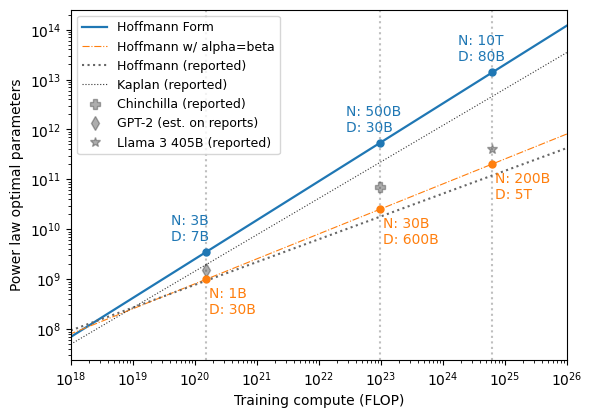

LBFGS [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
LBFGS (high tol) [9.95185271 9.92342656 0.72073436 0.56006009 0.47411257]
LBFGS (med tol) [5.01342362 9.92675332 0.58315703 0.27784136 0.47527045]
BFGS [6.20481875 9.45905364 0.6372093  0.34924348 0.45296726]
Nonlinear Least Squares [14.98182965 14.09646381  0.96116673  1.35814698 21.21753101]
Grid Search [ 7.   3.  -0.9  0.4  0.1]
BFGS
{9.8e+22: (1321571921.5480564, 'tab:brown', 'N: 1B\nD: 10T'), 1.5e+20: (361462992.40245104, 'tab:brown', 'N: 400M\nD: 70B'), 6.318e+24: (3040615549.457017, 'tab:brown', 'N: 3B\nD: 300T')}
{9.8e+22: (6.932603480432433e+20, 'tab:purple', 'N: 7e+08T\nD: 20'), 1.5e+20: (1.5671816254275507e+18, 'tab:purple', 'N: 2e+06T\nD: 20'), 6.318e+24: (3.4785613124046126e+22, 'tab:purple', 'N: 3e+10T\nD: 30')}


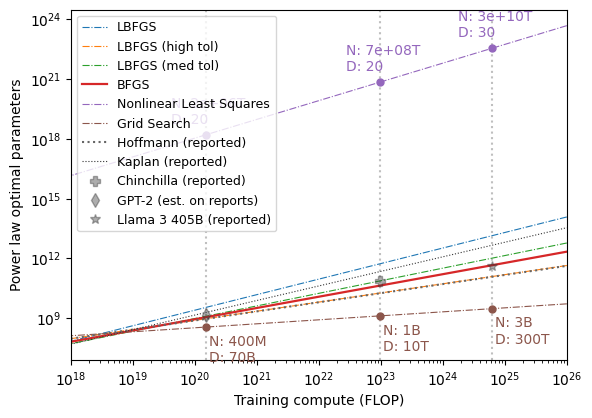

Optimize Full Grid [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
Search Grid, Optimize 1 [6.20912019 9.46007332 0.63739515 0.34949189 0.4530195 ]
Search Grid, Optimize 1000 [6.20547123 9.46097094 0.6372719  0.3492808  0.45306038]
Optimize 100 Random [6.20546942 9.46076957 0.63726112 0.34927938 0.45305005]
Initialize from Chinchilla [6.00728494 6.0180388  0.5276805  0.33921259 0.28461747]
Initialize from Chinchilla
{9.8e+22: (17750731673.592407, 'tab:purple', 'N: 20B\nD: 900B'), 1.5e+20: (922217897.7997658, 'tab:purple', 'N: 900M\nD: 30B'), 6.318e+24: (118773436614.05183, 'tab:purple', 'N: 100B\nD: 9T')}
{9.8e+22: (543005026964.2315, 'tab:blue', 'N: 500B\nD: 30B'), 1.5e+20: (3482228943.8468814, 'tab:blue', 'N: 3B\nD: 7B'), 6.318e+24: (13939985063775.533, 'tab:blue', 'N: 10T\nD: 80B')}


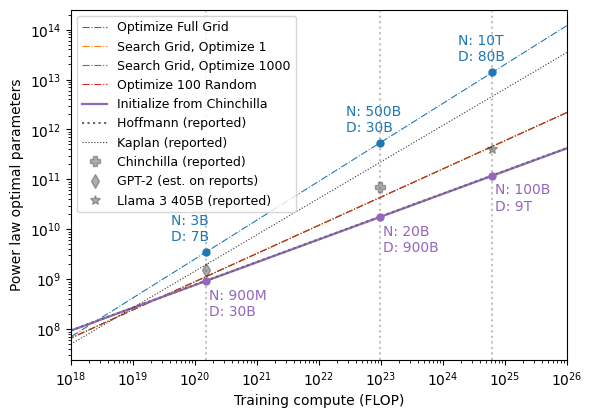

Log-Huber [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
Huber [ 6.14309949 10.44388073  0.65208809  0.34532827  0.5004308 ]
MSE [ 6.61935879 12.82267489  0.68905119  0.37209214  0.61204839]
MAE [6.14889858 9.4398466  0.63457794 0.34596562 0.45208601]
Huber
{9.8e+22: (44352671862.39085, 'tab:red', 'N: 40B\nD: 400B'), 1.5e+20: (1127670002.3156357, 'tab:red', 'N: 1B\nD: 20B'), 6.318e+24: (469780904659.5677, 'tab:red', 'N: 500B\nD: 2T')}
{9.8e+22: (543005026964.2315, 'tab:blue', 'N: 500B\nD: 30B'), 1.5e+20: (3482228943.8468814, 'tab:blue', 'N: 3B\nD: 7B'), 6.318e+24: (13939985063775.533, 'tab:blue', 'N: 10T\nD: 80B')}


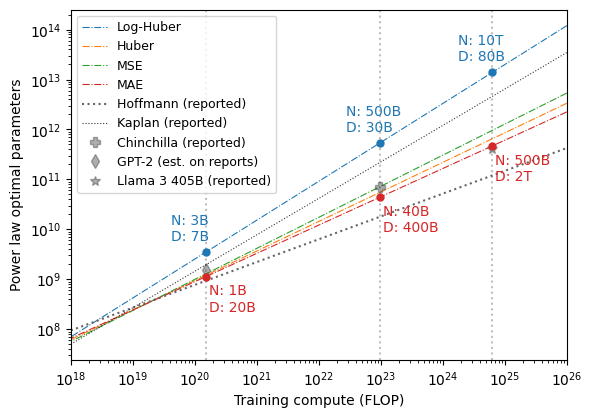

Hoffmann Form [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
Hoffmann w/ alpha=beta [12.54237538 15.07571348  0.9398387   0.75002079  0.75002079]
Hoffmann Form
{9.8e+22: (23609198440.470474, 'tab:orange', 'N: 20B\nD: 700B'), 1.5e+20: (923663610.7472476, 'tab:orange', 'N: 900M\nD: 30B'), 6.318e+24: (189564939005.8226, 'tab:orange', 'N: 200B\nD: 6T')}
{9.8e+22: (543005026964.2315, 'tab:blue', 'N: 500B\nD: 30B'), 1.5e+20: (3482228943.8468814, 'tab:blue', 'N: 3B\nD: 7B'), 6.318e+24: (13939985063775.533, 'tab:blue', 'N: 10T\nD: 80B')}


/var/folders/pc/yg40syl127q3j7xp3nm_zncc0000gn/T/ipykernel_75813/2684694884.py:134: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(LLMS[model][x_axis], LLMS[model][y_axis], 'o', color='0.2', marker=LLMS[model]["marker"], markersize=7, label=f"{model}", alpha=0.4)  # 'o' is the marker style for a filled circle


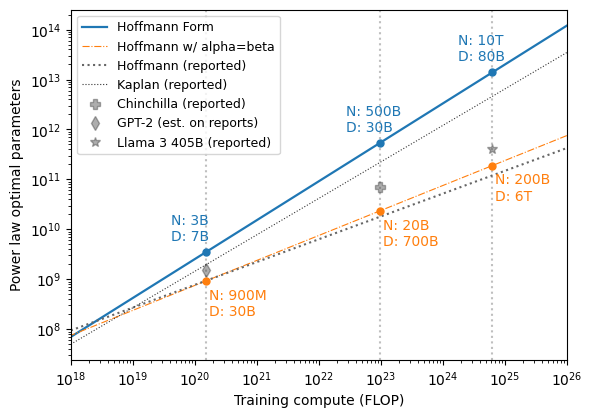

LBFGS [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
LBFGS (high tol) [20.00537704 14.96593231  1.05453192  1.40407422  0.74075637]
LBFGS (med tol) [ 5.00251201 14.96815053  0.70097389  0.28196905  0.74391348]
BFGS [ 3.97175577 15.02449449  0.55754137  0.21051102  0.74685235]
Nonlinear Least Squares [4.92095207e-04 1.24673099e-04 1.22813053e+00 4.91146990e-01
 4.97449816e-01]
Grid Search [ 4.  14.   0.4  0.2  0.7]
BFGS
{9.8e+22: (663101299.0363526, 'tab:orange', 'N: 700M\nD: 20T'), 1.5e+20: (70684097.3187177, 'tab:orange', 'N: 70M\nD: 400B'), 6.318e+24: (2795587770.601451, 'tab:orange', 'N: 3B\nD: 400T')}
{9.8e+22: (702783703969.7738, 'tab:brown', 'N: 700B\nD: 20B'), 1.5e+20: (5693322699.786989, 'tab:purple', 'N: 6B\nD: 4B'), 6.318e+24: (17951331325764.75, 'tab:brown', 'N: 20T\nD: 60B')}


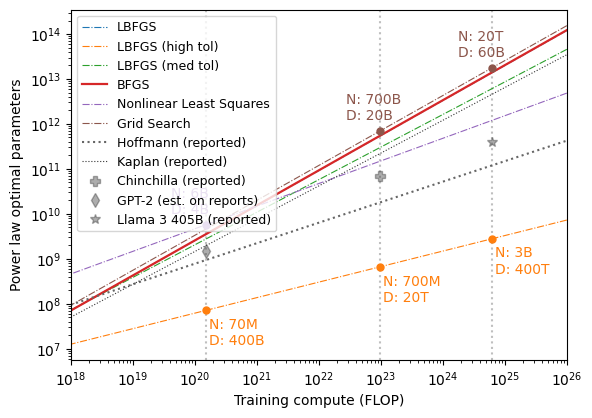

Optimize Full Grid [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
Search Grid, Optimize 1 [ 5.41054191 14.89675142  0.73538837  0.3091893   0.74021715]
Search Grid, Optimize 1000 [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
Optimize 100 Random [ 3.7511979  15.23602377  0.508502    0.19416313  0.7578849 ]
Initialize from Chinchilla [ 7.73908246 14.99738304  0.85223818  0.45842102  0.74551405]
Initialize from Chinchilla
{9.8e+22: (91480568073.93481, 'tab:purple', 'N: 90B\nD: 200B'), 1.5e+20: (1652379464.1041439, 'tab:purple', 'N: 2B\nD: 20B'), 6.318e+24: (1207082244278.1672, 'tab:purple', 'N: 1T\nD: 900B')}
{9.8e+22: (664721735944.1019, 'tab:red', 'N: 700B\nD: 20B'), 1.5e+20: (3816198156.7130547, 'tab:red', 'N: 4B\nD: 7B'), 6.318e+24: (18322688489279.707, 'tab:red', 'N: 20T\nD: 60B')}


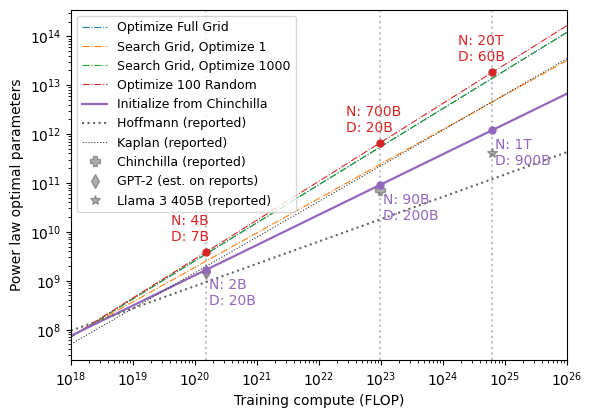

Log-Huber [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
Huber [ 3.76629425 14.97169742  0.51507949  0.19600154  0.74398552]
MSE [ 4.48251685 14.911392    0.67692612  0.24992042  0.74098925]
MAE [ 4.12706163 15.01270353  0.57870567  0.22081373  0.74628567]
Huber
{9.8e+22: (366060699790.5284, 'tab:green', 'N: 400B\nD: 40B'), 1.5e+20: (2873639110.475685, 'tab:green', 'N: 3B\nD: 9B'), 6.318e+24: (8252089841089.172, 'tab:green', 'N: 8T\nD: 100B')}
{9.8e+22: (613594892654.8397, 'tab:orange', 'N: 600B\nD: 30B'), 1.5e+20: (3628650704.1201043, 'tab:orange', 'N: 4B\nD: 7B'), 6.318e+24: (16594251364752.074, 'tab:orange', 'N: 20T\nD: 60B')}


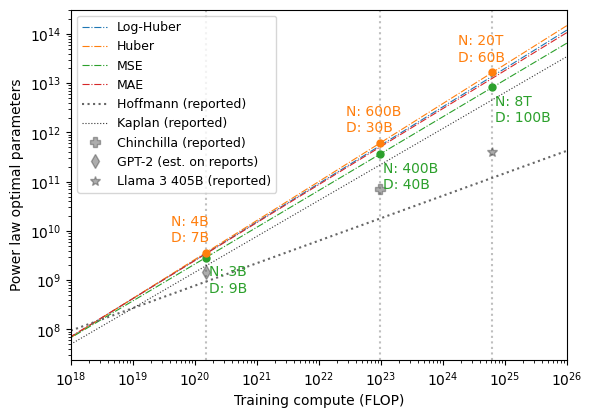

N, C w/ embed [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
N w/o embed [  2.01574495  15.25517198 -12.45594619   0.05419382   0.75887165]
C w/o embed [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
N & C w/o embed [  2.01574495  15.25517198 -12.45594619   0.05419382   0.75887165]
C=6ND approximation [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
C w/o embed
{9.8e+22: (543005026964.2315, 'tab:blue', 'N: 500B\nD: 30B'), 1.5e+20: (3482228943.8468814, 'tab:blue', 'N: 3B\nD: 7B'), 6.318e+24: (13939985063775.533, 'tab:blue', 'N: 10T\nD: 80B')}
{9.8e+22: (1782272661862.4666, 'tab:orange', 'N: 2T\nD: 9B'), 1.5e+20: (4202216943.198773, 'tab:orange', 'N: 4B\nD: 6B'), 6.318e+24: (87041745179266.1, 'tab:orange', 'N: 90T\nD: 10B')}


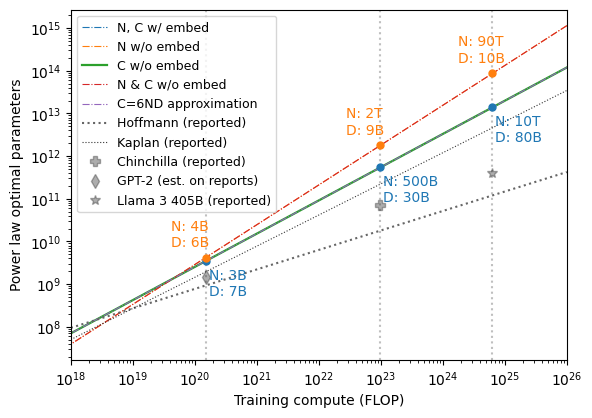

C4 [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
Wikipedia [ 2.94099012 14.84669608 -1.21751816  0.11880194  0.718631  ]
C4
{9.8e+22: (543005026964.2315, 'tab:blue', 'N: 500B\nD: 30B'), 1.5e+20: (3453913162.3817897, 'tab:orange', 'N: 3B\nD: 7B'), 6.318e+24: (13939985063775.533, 'tab:blue', 'N: 10T\nD: 80B')}
{9.8e+22: (899660708568.8143, 'tab:orange', 'N: 900B\nD: 20B'), 1.5e+20: (3482228943.8468814, 'tab:blue', 'N: 3B\nD: 7B'), 6.318e+24: (32118067180294.953, 'tab:orange', 'N: 30T\nD: 30B')}


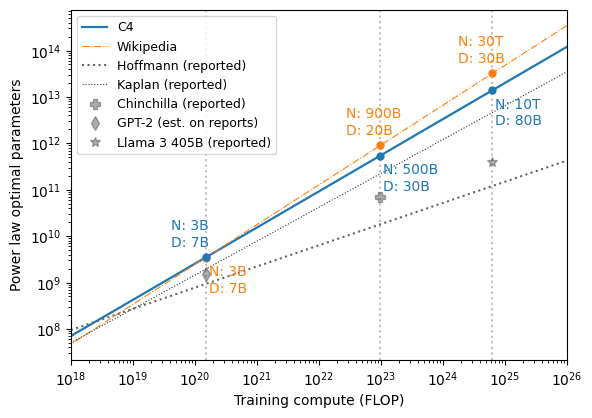

Sweep Learning Rate (LR) [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
Fixed LR = 1e-3 [14.63671572 13.46800969  0.88501241  0.8545604   0.66019429]
Fixed LR = 4e-3 [26.25487021 15.955392    1.03973765  1.56849247  0.79443091]
Use all LRs [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
Fixed LR = 1e-3
{9.8e+22: (3063440394.405692, 'tab:green', 'N: 3B\nD: 5T'), 1.5e+20: (346530900.0869316, 'tab:green', 'N: 300M\nD: 70B'), 6.318e+24: (12431582035.884796, 'tab:green', 'N: 10B\nD: 80T')}
{9.8e+22: (543005026964.2315, 'tab:blue', 'N: 500B\nD: 30B'), 1.5e+20: (3482228943.8468814, 'tab:blue', 'N: 3B\nD: 7B'), 6.318e+24: (13939985063775.533, 'tab:blue', 'N: 10T\nD: 80B')}


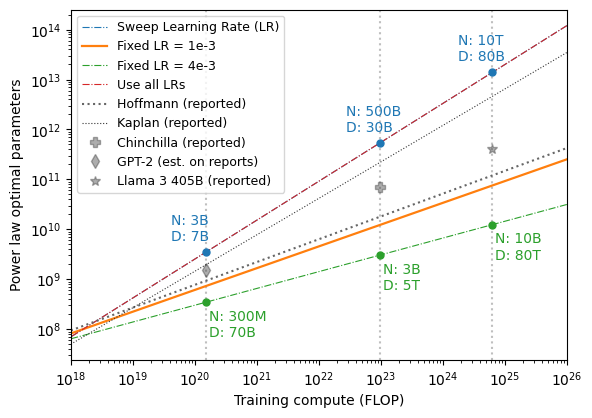

All Models [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
N <= 100M [17.95988142 15.69945361  1.00039815  1.07636571  0.78227314]
D/N <= 18 [  1.88802983  13.35325108 -11.22417967   0.04926859   0.65378532]
D/N >= 22 [16.04319714  9.63782826  0.92881575  0.95310567  0.48777188]
All Models
{9.8e+22: (4489633351.065616, 'tab:red', 'N: 4B\nD: 4T'), 1.5e+20: (500287540.62592936, 'tab:red', 'N: 500M\nD: 50B'), 6.318e+24: (18395889406.23352, 'tab:red', 'N: 20B\nD: 60T')}
{9.8e+22: (948288720571.2766, 'tab:green', 'N: 900B\nD: 20B'), 1.5e+20: (3482228943.8468814, 'tab:blue', 'N: 3B\nD: 7B'), 6.318e+24: (45656048303513.97, 'tab:green', 'N: 50T\nD: 20B')}


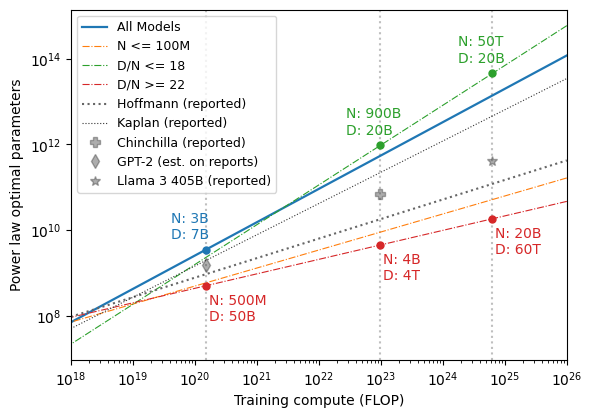

In [333]:
DATA_ARGS = {
    "epoch_ai":{
        "data_name": "epoch_ai",
        "loss_field_name": "loss",
    },
    "ours_wiki":{
        "data_name": "ours",
        "loss_field_name": 'Wiki Eval Loss',
    },
    "ours_c4_noemb_n":{
        "data_name": "ours",
        "loss_field_name": 'C4 Eval Loss',
        "n_field_name": "N_no_emb",
    },
    "ours_c4_noemb_c":{
        "data_name": "ours",
        "loss_field_name": 'C4 Eval Loss',
        "c_field_name": "Approx_C_no_emb",
    },
    "ours_c4_noemb_nc":{
        "data_name": "ours",
        "loss_field_name": 'C4 Eval Loss',
        "c_field_name": "Approx_C_no_emb",
        "n_field_name": "N_no_emb",
    },
    "ours_c4_approx_c":{
        "data_name": "ours",
        "loss_field_name": 'C4 Eval Loss',
        "c_field_name": "Approx_C",
    },
    "ours_fixed_lr_1e-3":{
        "data_name": "ours",
        "loss_field_name": 'C4 Eval Loss', 
        "data_selection": "fixed_lr_1e-3"
    },
    "ours_fixed_lr_4e-3":{
        "data_name": "ours",
        "loss_field_name": 'C4 Eval Loss', 
        "data_selection": "fixed_lr_4e-3"
    },
    "ours_max_model_100m":{
        "data_name": "ours",
        "loss_field_name": 'C4 Eval Loss', 
        "data_selection": "max_model_100m"
    },
    "ours_low_ratio":{
        "data_name": "ours",
        "loss_field_name": 'C4 Eval Loss', 
        "data_selection": "low_ratio"
    },
    "ours_high_ratio":{
        "data_name": "ours",
        "loss_field_name": 'C4 Eval Loss', 
        "data_selection": "high_ratio"
    },
    "ours_no_filtering":{
        "data_name": "ours",
        "loss_field_name": 'C4 Eval Loss', 
        "data_selection": "no"
    },
    # "ours_grid":{
    #     "data_name": "ours",
    #     "loss_field_name": 'C4 Eval Loss', 
    #     "data_selection": "no"
    # },
    # "ours_dense":{
    #     "data_name": "ours",
    #     "loss_field_name": 'C4 Eval Loss', 
    #     "data_selection": "no"
    # },
    "ours_c4":{
        "data_name": "ours",
        "loss_field_name": 'C4 Eval Loss', 
    },
    "rsld":{
        "data_name": "rsld",
        "loss_field_name": "loss",
    },
    "rsld":{
        "data_name": "rsld",
        "loss_field_name": "loss",
        "rsld_config_name": "kaplan",
    },
}


# results_dict = {}

# for dataset in ["epoch_ai", "ours_c4", "rsld"]:
for dataset in ["epoch_ai", "ours_c4"]:
# for dataset in ["ours_c4"]:
# for dataset in ["epoch_ai"]:
    dataset_dict=DATA_ARGS[dataset]
    data_name=dataset_dict['data_name']
    
    x_axis="C"
    y_axis="N"
    
    # results_dict[data_name] = {}
    # # N, D, losses, indices = get_data(data_name, loss_field_name=dataset_dict["loss_field_name"], )
    N, D, losses, indices = get_data(**dataset_dict)
    # chinchilla_result = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber")

    grp = 'form'
    # results_dict[data_name][grp] = {}
    # results_dict[data_name][grp]['Hoffmann Form'] = chinchilla_result
    # # results_dict[data_name][grp]['Kaplan Form'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", form='kaplan')
    # results_dict[data_name][grp]['Hoffmann w/ alpha=beta'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", form='chinchilla', tie_alpha_beta=True)
    plot_lines(results_dict[data_name][grp], x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)
    # # plot_keys = ['Hoffmann Form',  'Hoffmann w/ alpha=beta'] #,'Kaplan Form']
    # # plot_group = {k:results_dict[data_name][grp][k] for k in plot_keys}
    # # plot_lines(plot_group, x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)
    
    grp = 'opt'
    # results_dict[data_name][grp] = {}
    # results_dict[data_name][grp]['LBFGS'] = chinchilla_result
    # results_dict[data_name][grp]['LBFGS (high tol)'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", tol=1e-4)
    # results_dict[data_name][grp]['LBFGS (med tol)'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", tol=1e-6)
    # results_dict[data_name][grp]['BFGS'] = fit_perf_power_law(N, D, losses, indices, method="BFGS", obj_name="log_huber")
    # results_dict[data_name][grp]['Nonlinear Least Squares'] = fit_perf_power_law(N, D, losses, indices, method="nonlinear_least_squares")
    # results_dict[data_name][grp]['Grid Search'] = fit_perf_power_law(N, D, losses, indices, method="grid", dense_init=True)
    
    # results_dict[data_name][grp]['LBFGS (low tol)'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", tol=1e-8)
    # results_dict[data_name][grp]['LBFGS (gradient)'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", use_grad=True)
    # results_dict[data_name][grp]['BFGS (gradient)'] = fit_perf_power_law(N, D, losses, indices, method="BFGS", obj_name="log_huber", use_grad=True)
    # results_dict[data_name][grp]['BFGS (high tol)'] = fit_perf_power_law(N, D, losses, indices, method="BFGS", obj_name="log_huber", tol=1e-4)
    # results_dict[data_name][grp]['BFGS (low tol)'] = fit_perf_power_law(N, D, losses, indices, method="BFGS", obj_name="log_huber", tol=1e-8)
    # print(results_dict[data_name][grp].keys())
    # plot_lines(results_dict[data_name][grp], x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)
    plot_keys = ['LBFGS', 'LBFGS (high tol)', 'LBFGS (med tol)', 'BFGS', 'Nonlinear Least Squares', 'Grid Search']
    # plot_keys = ['LBFGS',  'LBFGS (low tol)',  'Nonlinear Least Squares'] #'LBFGS (gradient)', 'BFGS', 'LBFGS (high tol)',
    plot_group = {k:results_dict[data_name][grp][k] for k in plot_keys}
    plot_lines(plot_group, x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)

    grp = 'init'
    # results_dict[data_name][grp] = {}
    # results_dict[data_name][grp]['Optimize Full Grid'] = chinchilla_result
    # results_dict[data_name][grp]['Search Grid, Optimize 1'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", keep_best_k_from_init_grid=1)
    # results_dict[data_name][grp]['Search Grid, Optimize 1000'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", keep_best_k_from_init_grid=1000)
    # results_dict[data_name][grp]['Optimize 100 Random'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", max_opt_inits=100)
    # results_dict[data_name][grp]['Initialize from Chinchilla'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", init_grid=[[v] for v in CHINCHILLA_PARAMS_LOG])
    # print(results_dict[data_name][grp].keys())
    # plot_lines(results_dict[data_name][grp], x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)
    # plot_keys = ['Optimize Full Grid', 'Search Grid, Optimize 1', 'Search Grid, Optimize 1000', 'Optimize 100 Random', 'Initialize from Chinchilla']
    plot_keys = ['Optimize Full Grid', 'Search Grid, Optimize 1', 'Search Grid, Optimize 1000', 'Optimize 100 Random', 'Initialize from Chinchilla']
    plot_group = {k:results_dict[data_name][grp][k] for k in plot_keys}
    plot_lines(plot_group, x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)

    grp = 'loss'
    # results_dict[data_name][grp] = {}
    # results_dict[data_name][grp]['Log-Huber'] = chinchilla_result
    # results_dict[data_name][grp]['Huber'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="huber")
    # # results_dict[data_name]['scale'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="scale")
    # # results_dict[data_name]['base'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="base")
    # # results_dict[data_name]['constant'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="constant")
    # results_dict[data_name][grp]['MSE'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_mse")
    # results_dict[data_name][grp]['MAE'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_mae")
    # # results_dict['Scaled Log-Huber'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="scaled_log_huber")
    # print(results_dict[data_name][grp].keys())
    # plot_lines(results_dict[data_name][grp], x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)
    plot_keys = ['Log-Huber', 'Huber', 'MSE', 'MAE']
    plot_group = {k:results_dict[data_name][grp][k] for k in plot_keys}
    plot_lines(plot_group, x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True, highlight_low=False)

    if data_name == "ours":
        grp = "counting"
        # results_dict[data_name][grp] = {}
        # results_dict[data_name][grp]["N, C w/ embed"] = chinchilla_result
        # for dkey, sub_dataset in [("N w/o embed","ours_c4_noemb_n"), ("C w/o embed", "ours_c4_noemb_c"), ("N & C w/o embed", "ours_c4_noemb_nc"), ("C=6ND approximation", "ours_c4_approx_c")]:
        #     dataset_dict=DATA_ARGS[sub_dataset]
        #     data_name=dataset_dict['data_name']
        #     N, D, losses, indices = get_data(**dataset_dict)
        #     results_dict[data_name][grp][dkey] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber")
        # print(results_dict[data_name][grp].keys())
        plot_lines(results_dict[data_name][grp], x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)
        # plot_keys = ['N, C w/ emb', 'N, C w/o embed']
        # plot_group = {k:results_dict[data_name][grp][k] for k in plot_keys}
        # plot_lines(plot_group, x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)

        grp = "eval"
        # results_dict[data_name][grp] = {}
        # results_dict[data_name][grp]["C4"] = chinchilla_result
        # for dkey, sub_dataset in [("Wikipedia", "ours_wiki")]:
        #     dataset_dict=DATA_ARGS[sub_dataset]
        #     data_name=dataset_dict['data_name']
        #     N, D, losses, indices = get_data(**dataset_dict)
        #     results_dict[data_name][grp][dkey] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber")
        # print(results_dict[data_name][grp].keys())
        # plot_lines(results_dict[data_name][grp], x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)
        plot_keys = ['C4', 'Wikipedia']
        plot_group = {k:results_dict[data_name][grp][k] for k in plot_keys}
        plot_lines(plot_group, x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)

        # grp = "train"
        # # results_dict[data_name][grp] = {}
        # results_dict[data_name][grp]["Sweep Learning Rate (LR)"] = chinchilla_result
        # for dkey, sub_dataset in [
        #     ("Fixed LR = 1e-3", "ours_fixed_lr_1e-3"), ("Fixed LR = 4e-3", "ours_fixed_lr_4e-3"), ("N <= 100M", "ours_max_model_100m"), 
        #     ("D/N <= 18", "ours_low_ratio"),
        #     ("D/N >= 22", "ours_high_ratio"),
        #     ("Use all LRs", "ours_no_filtering"),
        # ]:
        #     dataset_dict=DATA_ARGS[sub_dataset]
        #     data_name=dataset_dict['data_name']
        #     N, D, losses, indices = get_data(**dataset_dict)
        #     results_dict[data_name][grp][dkey] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber")
        # # print(results_dict[data_name][grp].keys())
        # # plot_lines(results_dict[data_name][grp], x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)
        # plot_keys = ["Sweep Learning Rate (LR)","Fixed LR = 1e-3","Fixed LR = 4e-3","N <= 100M","D/N <= 18", "D/N >= 22","Use all LRs"]
        # plot_group = {k:results_dict[data_name][grp][k] for k in plot_keys}
        # plot_lines(plot_group, x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)


        grp = "lr"
        # results_dict[data_name][grp] = {}
        # results_dict[data_name][grp]["Sweep Learning Rate (LR)"] = chinchilla_result
        # for dkey, sub_dataset in [
        #     ("Fixed LR = 1e-3", "ours_fixed_lr_1e-3"), 
        #     ("Fixed LR = 4e-3", "ours_fixed_lr_4e-3"),
        #     ("Use all LRs", "ours_no_filtering"),
        # ]:
        #     dataset_dict=DATA_ARGS[sub_dataset]
        #     data_name=dataset_dict['data_name']
        #     N, D, losses, indices = get_data(**dataset_dict)
        #     results_dict[data_name][grp][dkey] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber")
        # print(results_dict[data_name][grp].keys())
        # plot_lines(results_dict[data_name][grp], x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)
        plot_keys = ["Sweep Learning Rate (LR)","Fixed LR = 1e-3","Fixed LR = 4e-3","Use all LRs"]
        plot_group = {k:results_dict[data_name][grp][k] for k in plot_keys}
        plot_lines(plot_group, x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)

        grp = "nd"
        # results_dict[data_name][grp] = {}
        # results_dict[data_name][grp]["All Models"] = chinchilla_result
        # for dkey, sub_dataset in [
        #     ("N <= 100M", "ours_max_model_100m"), 
        #     ("D/N <= 18", "ours_low_ratio"),
        #     ("D/N >= 22", "ours_high_ratio"),
        # ]:
        #     dataset_dict=DATA_ARGS[sub_dataset]
        #     data_name=dataset_dict['data_name']
        #     N, D, losses, indices = get_data(**dataset_dict)
        #     results_dict[data_name][grp][dkey] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber")
        # # print(results_dict[data_name][grp].keys())
        # plot_lines(results_dict[data_name][grp], x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)
        plot_keys = ["All Models","N <= 100M","D/N <= 18", "D/N >= 22"]
        plot_group = {k:results_dict[data_name][grp][k] for k in plot_keys}
        plot_lines(plot_group, x_axis=x_axis, y_axis=y_axis, save_as=f"analysis_{grp}_{data_name}_{x_axis}_vs_{y_axis}", add_reference_points=True)




LBFGS [ 3.98963855 15.01841036  0.56111979  0.21180797  0.74653212]
LBFGS (high tol) [20.00537704 14.96593231  1.05453192  1.40407422  0.74075637]
LBFGS
{9.8e+22: (663101299.0363526, 'tab:orange', 'N: 700M\nD: 20T'), 6.318e+24: (2795587770.601451, 'tab:orange', 'N: 3B\nD: 400T')}
{9.8e+22: (543005026964.2315, 'tab:blue', 'N: 500B\nD: 30B'), 6.318e+24: (13939985063775.533, 'tab:blue', 'N: 10T\nD: 80B')}


/var/folders/pc/yg40syl127q3j7xp3nm_zncc0000gn/T/ipykernel_75813/519208267.py:143: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(LLMS[model][x_axis], LLMS[model][y_axis], 'o', color='black', marker=LLMS[model]["marker"], markersize=5, label=f"{model} model", alpha=0.75)  # 'o' is the marker style for a filled circle


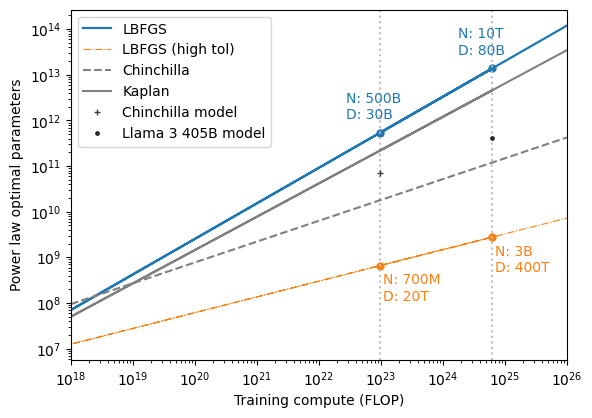

In [229]:
# 'LBFGS (high tol)', 'LBFGS (low tol)', 'LBFGS (w/ gradient)', 'BFGS', 'Nonlinear Least Squares', 'LBFGS (med tol)', 'BFGS (w/ gradient)', 'BFGS (high tol)', 'BFGS (low tol)']
dataset = "ours_c4"
dataset_dict=DATA_ARGS[dataset]
data_name=dataset_dict['data_name']
grp = "opt"
plot_keys = ['LBFGS', 'LBFGS (high tol)']
plot_group = {k:results_dict[data_name][grp][k] for k in plot_keys}
plot_lines(plot_group, save_as=f"_test", add_reference_points=True)


Index(['Params', 'total steps', 'lr', 'Avg Train Loss', 'Max Train Loss',
       'C4 Eval PPL', 'Wiki Eval PPL', 'C4 Eval Loss', 'Wiki Eval Loss', 'C',
       'Approx_C_no_emb', 'Approx_C', 'D', 'N_no_emb', 'N',
       'total train ZFLOPs', 'goal train tokens', 'tok / sec', 'act. check?',
       'vocab', 'num GPUs', 'local bsz', 'batch size', 'seq len',
       'tok / batch', 'layers', 'model dim', 'FFN dim', 'n heads', 'head size',
       'attn params / layer', 'FFN params / layer', 'params / layer',
       'total norm params', 'total non-emb params', 'total emb params',
       'NEW # params', 'HW TFLOP/s/GPU', 'Model FLOP Util', 'days to finish',
       'attn FLOPS per layer-token', 'Proj FLOPs per layer-token',
       'FFN FLOPs per layer-token', 'Body FLOPs', 'logits FLOPS',
       'FLOPs / update', 'FLOPS / update w/ rema', '% FLOPS Proj',
       '% FLOPS FFN', '% FLOPS logit', '% FLOPS attn', 'updates per second'],
      dtype='object')
best loss: 0.0006025076218596852 : best para

/var/folders/pc/yg40syl127q3j7xp3nm_zncc0000gn/T/ipykernel_75813/2668125192.py:135: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(LLMS[model][x_axis], LLMS[model][y_axis], 'o', color='black', marker=LLMS[model]["marker"], markersize=5, label=f"{model} model", alpha=0.75)  # 'o' is the marker style for a filled circle


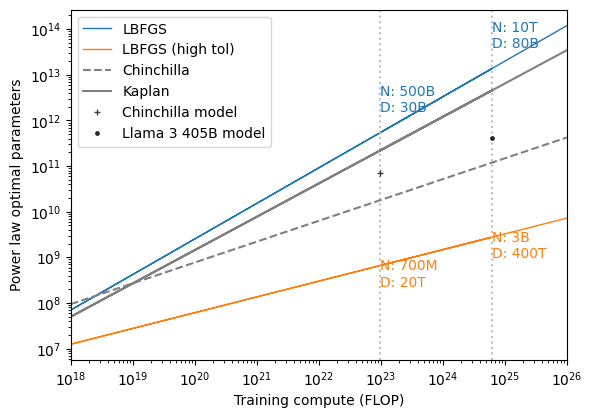

In [131]:
## experiment with optimizers
## pq, best_loss, best_params, ratio, predicted_model_loss
results_dict = {}
# for dataset in ["epoch_ai", "ours_c4", "rsld"]:
dataset = "ours_c4"
dataset_dict=DATA_ARGS[dataset]
data_name=dataset_dict['data_name']
grp = "opt"

x_axis="C"
y_axis="N"

results_dict[data_name] = {}
results_dict[data_name][grp] = {}
# N, D, losses, indices = get_data(data_name, loss_field_name=dataset_dict["loss_field_name"], )
N, D, losses, indices = get_data(**dataset_dict)
chinchilla_result = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber")
results_dict[data_name][grp]['LBFGS'] = chinchilla_result
results_dict[data_name][grp]['LBFGS (high tol)'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", tol=1e-4)
# results_dict[data_name][grp]['LBFGS (low tol)'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", tol=1e-8)
# results_dict[data_name][grp]['LBFGS (w/ gradient)'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", use_grad=True)
# results_dict[data_name][grp]['BFGS'] = fit_perf_power_law(N, D, losses, indices, method="BFGS", obj_name="log_huber")
# results_dict[data_name][grp]['Nonlinear Least Squares'] = fit_perf_power_law(N, D, losses, indices, method="nonlinear_least_squares")

# results_dict[data_name][grp]['LBFGS (med tol)'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", tol=1e-6)
# results_dict[data_name][grp]['BFGS (w/ gradient)'] = fit_perf_power_law(N, D, losses, indices, method="BFGS", obj_name="log_huber", use_grad=True)
# results_dict[data_name][grp]['BFGS (high tol)'] = fit_perf_power_law(N, D, losses, indices, method="BFGS", obj_name="log_huber", tol=1e-4)
# results_dict[data_name][grp]['BFGS (low tol)'] = fit_perf_power_law(N, D, losses, indices, method="BFGS", obj_name="log_huber", tol=1e-8)

plot_lines(results_dict[data_name][grp], save_as=f"analysis_{dataset}_opt", add_reference_points=True)


In [ ]:
## experiment with init
# pq, best_loss, best_params, ratio, predicted_model_loss
results_dict = {}
results_dict['run_whole_grid'] = chinchilla_result
results_dict['keep_1_from_grid'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", keep_best_k_from_init_grid=1)
results_dict['keep_1000_from_grid'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", keep_best_k_from_init_grid=1000)
results_dict['randomly_sample_100'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", max_opt_inits=100)
results_dict['init_from_chinchilla'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", init_grid=[[v] for v in CHINCHILLA_PARAMS_LOG])

plot_lines(results_dict, x_axis="C", y_axis="D/N", save_as="analysis_init_epoch")

In [123]:
## experiment with init
# pq, best_loss, best_params, ratio, predicted_model_loss
results_dict = {}
results_dict['chinchilla_form'] = chinchilla_result
# results_dict['kaplan_form'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", form='kaplan')
results_dict['chinchilla_tie_alpha_beta'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", form='chinchilla', tie_alpha_beta=True)
plot_lines(results_dict, x_axis="C", y_axis="D/N", save_as="analysis_form_epoch")

Best fit parameters: A=279952.5442343279, B=3526136.9411928253, E=2.5595685265068386, alpha=0.750020792397985, beta=0.750020792397985
Best loss: 0.0006611063660827383

Parameter estimates and their standard errors
A: 279952.54423 (157694436.36896)
B: 3526136.94119 (307850359.41904)
E: 2.55957 (0.50325)
alpha: 0.75002 (0.36720)
beta: 0.75002 (0.36720)
{}
{}


/var/folders/pc/yg40syl127q3j7xp3nm_zncc0000gn/T/ipykernel_75813/1803268707.py:135: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(LLMS[model][x_axis], LLMS[model][y_axis], 'o', color='black', marker=LLMS[model]["marker"], markersize=5, label=f"{model} model", alpha=0.75)  # 'o' is the marker style for a filled circle


KeyboardInterrupt: 

In [ ]:
## experiment with losses
results_dict = {}
results_dict['log_huber'] = chinchilla_result
results_dict['huber'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="huber")
# results_dict['scale'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="scale")
# results_dict['base'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="base")
# results_dict['constant'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="constant")
results_dict['mse'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_mse")
results_dict['mae'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_mae")
# results_dict['scaled_log_huber'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="scaled_log_huber")


plot_lines(results_dict, x_axis="C", y_axis="D/N", save_as="analysis_loss_epoch")


In [ ]:
N, D, losses, indices = get_data("ours")
chinchilla_result = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber")


In [ ]:
## experiment with optimizers
# pq, best_loss, best_params, ratio, predicted_model_loss
results_dict = {}
results_dict['lbfgs'] = chinchilla_result
results_dict['bfgs'] = fit_perf_power_law(N, D, losses, indices, method="BFGS", obj_name="log_huber")
results_dict['bfgs_w_grad'] = fit_perf_power_law(N, D, losses, indices, method="BFGS", obj_name="log_huber", use_grad=True)
results_dict['nonlinear_least_squares'] = fit_perf_power_law(N, D, losses, indices, method="nonlinear_least_squares")


plot_compute_ratio_lines(results_dict, save_as="analysis_opt_ours")


In [ ]:
## experiment with init
# pq, best_loss, best_params, ratio, predicted_model_loss
results_dict = {}
results_dict['run_whole_grid'] = chinchilla_result
results_dict['keep_1_from_grid'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", keep_best_k_from_init_grid=1)
results_dict['keep_100_from_grid'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", keep_best_k_from_init_grid=100)
results_dict['randomly_sample_100'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", max_opt_inits=100)
results_dict['init_from_chinchilla'] = fit_perf_power_law(N, D, losses, indices, method="L-BFGS-B", obj_name="log_huber", init_grid=[[v] for v in CHINCHILLA_PARAMS_LOG])

plot_lines(results_dict, x_axis="C", y_axis="D/N", save_as="analysis_init_ours")

In [ ]:
N, D, losses, indices = get_data("rsld", rsld_config_name="kaplan")

In [ ]:
pq, best_loss, best_params = fit_perf_power_law(N, D, losses, indices, obj=huber_loss_objective, method='L-BFGS-B', use_grad=False)


In [ ]:
# array([6.0073379 , 6.01786302, 0.52472853, 0.34      , 0.28      ])
init_param_grid = [[c] for c in CHINCHILLA_PARAMS_LOG]
fit_perf_power_law(N, D, losses, indices, obj=huber_loss_objective, method='L-BFGS-B', use_grad=False, init_params=init_params)

In [ ]:
huber_loss_objective(CHINCHILLA_PARAMS_LOG, N, D, losses)

In [ ]:
fit_perf_power_law(N, D, losses, indices, obj=huber_loss_objective, method='L-BFGS-B', use_grad=False)

In [ ]:
fit_perf_power_law(N, D, losses, indices, obj=huber_loss_objective, method='BFGS', use_grad=False)